<a href="https://colab.research.google.com/github/AbhinavKumar0000/FloatChat/blob/main/Argo_Float_1902671_DataAnalysis_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Argo Float 1902671 Data Analysis and Visualization

## Float Information
The Argo float with Reference ID 1902671 (WMO ID 1902671, WIGOS ID 0-22000-0-1902671) is part of the Argo INDIA program, managed by India. It is an **ARVOR** model float (serial number 23014) deployed by the ship **SAGAR NIDHI (41SN - India)**.

**Key Details**:
- **Status**: OPERATIONAL (with historical status changes: Registered on 2023-10-12, Operational on 2023-10-12, Inactive on 2024-08-16, Operational on 2024-09-12, Inactive on 2025-05-02, Operational on 2025-05-12)
- **Country**: India
- **Telecom**: IRIDIUM (#890540)
- **Networks**: Argo, Argo Global, Argo Core
- **Deployment**: Latitude 17.44, Longitude 69.31, Date 2023-10-09T16:34:00
- **Latest Observation (Cycle #71)**: Latitude 18.9, Longitude 69.3, Date 2025-09-08T14:03:19
- **Technical Details**: Cycle time 240 hours, Drift pressure 1000 dbar, Profile pressure 2000 dbar

## Notebook Objective
This notebook processes and visualizes data from the Argo float, combining sea temperature and practical salinity datasets into a standard format. The data spans from October 2023 to May 2025, capturing vertical profiles of temperature and salinity at various pressures (approximating depths, where 1 dbar ≈ 1 meter). Visualizations include creative 2D and 3D plots to help researchers analyze ocean stratification, water masses, and temporal changes. All data has a quality control flag (QC=1), indicating good quality.

The following visualizations are included:
1. **2D Waterfall Plot**: Temperature profiles over cycles with an offset for a pseudo-3D effect.
2. **T-S Diagram with Density Contours**: Temperature vs. salinity colored by pressure to identify water masses.
3. **Time-Series Heatmap**: Interpolated temperature over time and pressure for temporal trends.
4. **3D Interactive Scatter**: Temperature, salinity, and pressure colored by date for interactive exploration.
5. **3D Surface Plot**: Interpolated temperature surface over time and pressure.
6. **Animated Contour Plot**: Salinity contours vs. temperature and pressure, animated by cycle.

These plots are designed to be visually appealing and scientifically informative, leveraging libraries like Plotly, Seaborn, and Matplotlib.

## Install and Import Libraries
This cell installs required Python libraries and imports them for data processing and visualization. We use:
- **pandas** for data manipulation
- **plotly** for interactive 3D and animated plots
- **seaborn** and **matplotlib** for high-quality 2D visualizations
- **scipy** for interpolation in 3D surface plots
- **numpy** for numerical operations

In [8]:
!pip install pandas plotly seaborn matplotlib scipy
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np


## Load Temperature Data
We load the temperature dataset from the file `ST_1902671_23014_Sea_temperature_adjusted_09102023_29082025.csv`. The dataset contains:
- **Datetime**: Timestamp of the measurement
- **Sea pressure - decibar**: Pressure (dbar, approximating depth in meters)
- **Sea temperature adjusted**: Temperature in °C
- **QC**: Quality control flag (1 = good data)

The columns are renamed for consistency (`date`, `pressure`, `temperature`, `qc_temp`), and the `date` column is converted to datetime format.

In [9]:
# Load temperature data
temp_df = pd.read_csv('ST_1902671_23014_Sea_temperature_adjusted_09102023_29082025.csv')
temp_df.rename(columns={
    'Datetime': 'date',
    'Sea pressure - decibar': 'pressure',
    'Sea temperature adjusted': 'temperature',
    'QC': 'qc_temp'
}, inplace=True)
temp_df['date'] = pd.to_datetime(temp_df['date'])
temp_df.head()

,date,pressure,temperature,qc_temp
0,2023-10-19 19:27:55,0.4,29.571,1
1,2023-10-19 19:27:55,1.9,29.581,1
2,2023-10-19 19:27:55,3.7,29.420,1
3,2023-10-19 19:27:55,5.6,29.398,1
4,2023-10-19 19:27:55,8.4,29.412,1


## Load Salinity Data
We load the salinity dataset from the file `ST_1902671_23014_Practical_salinity_adjusted_09102023_29082025.csv`. The dataset contains:
- **Datetime**: Timestamp of the measurement
- **Sea pressure - decibar**: Pressure (dbar)
- **Practical salinity adjusted**: Salinity in PSU (Practical Salinity Units)
- **QC**: Quality control flag (1 = good data)

The columns are renamed (`date`, `pressure`, `salinity`, `qc_sal`), and the `date` column is converted to datetime format.

In [10]:
# Load salinity data
sal_df = pd.read_csv('ST_1902671_23014_Practical_salinity_adjusted_09102023_29082025.csv')
sal_df.rename(columns={
    'Datetime': 'date',
    'Sea pressure - decibar': 'pressure',
    'Practical salinity adjusted': 'salinity',
    'QC': 'qc_sal'
}, inplace=True)
sal_df['date'] = pd.to_datetime(sal_df['date'])
sal_df.head()

,date,pressure,salinity,qc_sal
0,2023-10-19 19:27:55,0.4,36.416,1
1,2023-10-19 19:27:55,1.9,36.395,1
2,2023-10-19 19:27:55,3.7,36.521,1
3,2023-10-19 19:27:55,5.6,36.553,1
4,2023-10-19 19:27:55,6.9,36.581,1


## Combine Data into Standard Format
We merge the temperature and salinity datasets on `date` and `pressure` to create a unified dataset with the following columns:
- `date`: Datetime of the profile
- `pressure`: Pressure in dbar (approximating depth)
- `temperature`: Sea temperature in °C
- `salinity`: Practical salinity in PSU
- `qc_temp` and `qc_sal`: Quality control flags
- `cycle`: Profile number (each unique date represents a cycle)

We filter for good quality data (QC=1) and assign cycle numbers based on unique dates. The data is sorted by date and pressure for consistency.

In [11]:
# Merge temperature and salinity data
merged_df = pd.merge(temp_df, sal_df, on=['date', 'pressure'], how='inner')

# Filter for good quality data (QC=1)
merged_df = merged_df[(merged_df['qc_temp'] == 1) & (merged_df['qc_sal'] == 1)]

# Assign cycle numbers based on unique dates
unique_dates = merged_df['date'].unique()
cycle_map = {date: i+1 for i, date in enumerate(sorted(unique_dates))}
merged_df['cycle'] = merged_df['date'].map(cycle_map)

# Sort by date and pressure
merged_df.sort_values(['date', 'pressure'], inplace=True)

# Display the first few rows of the standard dataset
merged_df.head()

,date,pressure,temperature,qc_temp,salinity,qc_sal,cycle
0,2023-10-19 19:27:55,0.4,29.571,1,36.416,1,1
1,2023-10-19 19:27:55,1.9,29.581,1,36.395,1,1
2,2023-10-19 19:27:55,3.7,29.420,1,36.521,1,1
3,2023-10-19 19:27:55,5.6,29.398,1,36.553,1,1
4,2023-10-19 19:27:55,10.3,29.416,1,36.617,1,1


## Data Summary
The combined dataset contains vertical profiles of temperature and salinity from October 2023 to May 2025, with pressures ranging from near-surface (0 dbar) to approximately 2000 dbar. The data shows:
- **Temperature**: Decreases with depth, indicating thermocline layers.
- **Salinity**: Varies with depth and time, potentially reflecting water mass changes.
- **Cycles**: Each cycle corresponds to a vertical profile taken approximately every 10 days (based on the 240-hour cycle time).

The dataset lacks latitude/longitude data, so visualizations focus on time, pressure, temperature, and salinity. For trajectory analysis, additional data from Argo portals (e.g., Argovis or Euro-Argo) could be integrated.

In [12]:
# Print basic statistics
print("Data Summary:")
print(f"Number of profiles (cycles): {len(merged_df['cycle'].unique())}")
print(f"Pressure range: {merged_df['pressure'].min():.1f} to {merged_df['pressure'].max():.1f} dbar")
print(f"Temperature range: {merged_df['temperature'].min():.2f} to {merged_df['temperature'].max():.2f} °C")
print(f"Salinity range: {merged_df['salinity'].min():.2f} to {merged_df['salinity'].max():.2f} PSU")

Data Summary:
Number of profiles (cycles): 59
Pressure range: 0.0 to 2031.8 dbar
Temperature range: 2.88 to 31.71 °C
Salinity range: 34.82 to 36.69 PSU


## 2D Waterfall Plot of Temperature Profiles
This plot visualizes temperature profiles (temperature vs. pressure) for the first 10 cycles, offset horizontally to create a pseudo-3D waterfall effect. The plot highlights the evolution of the vertical temperature structure over time, making it easy to spot changes in the thermocline or surface warming. The inverted y-axis represents increasing depth.


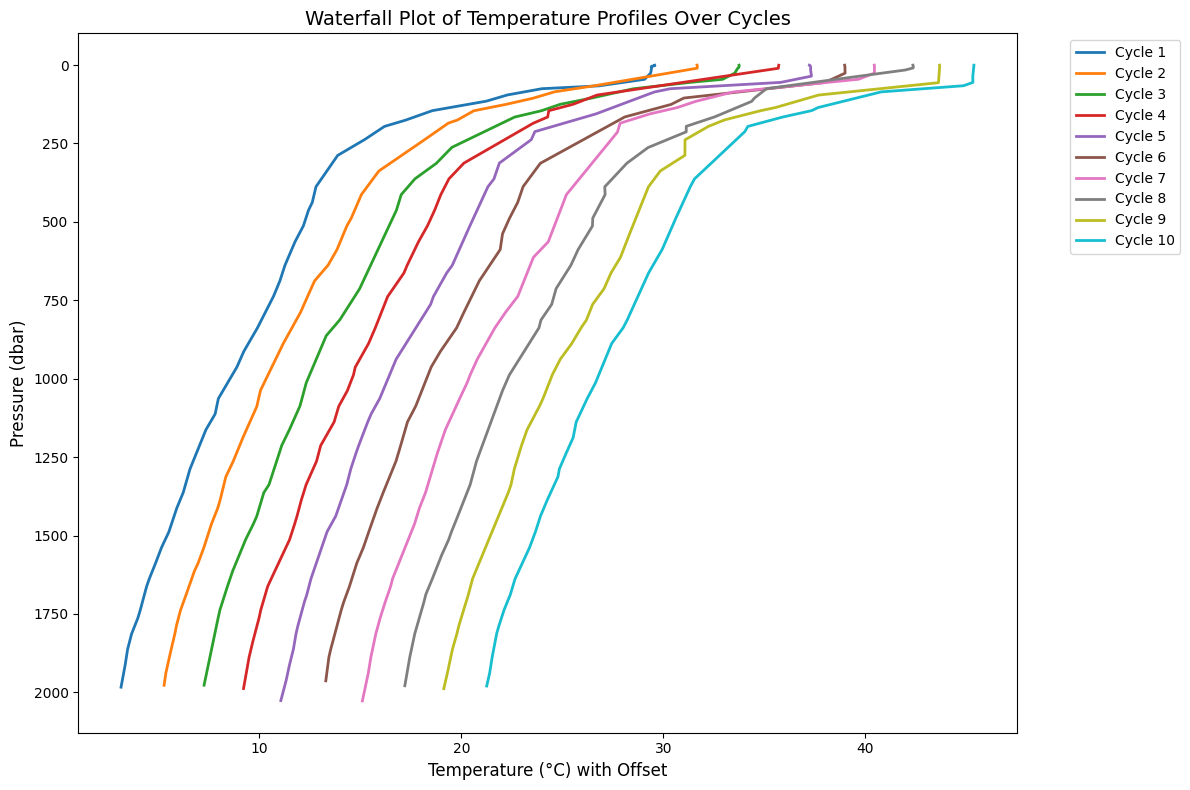

In [13]:
# Select first 10 cycles for clarity
subset = merged_df[merged_df['cycle'].isin(range(1, 11))]

fig, ax = plt.subplots(figsize=(12, 8))
offset = 0
for cycle, group in subset.groupby('cycle'):
    ax.plot(group['temperature'] + offset, group['pressure'], label=f'Cycle {cycle}', linewidth=2)
    offset += 2  # Offset for visual separation

ax.invert_yaxis()  # Depth increases downward
ax.set_xlabel('Temperature (°C) with Offset', fontsize=12)
ax.set_ylabel('Pressure (dbar)', fontsize=12)
ax.set_title('Waterfall Plot of Temperature Profiles Over Cycles', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## T-S Diagram with Density Contours
The Temperature-Salinity (T-S) diagram plots temperature against salinity, colored by pressure, with density contours overlaid. This visualization helps identify water masses based on their temperature-salinity signatures. The viridis colormap indicates depth, and red density contours highlight clusters of data points, revealing oceanographic features like water mass boundaries.

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

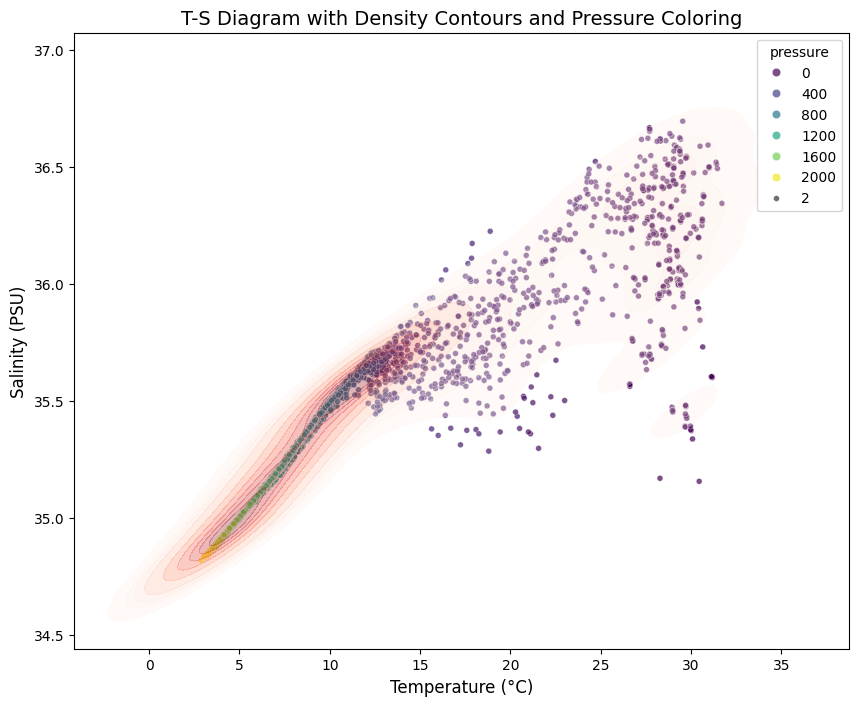

In [14]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=merged_df, x='temperature', y='salinity', hue='pressure', palette='viridis', alpha=0.7, size=2)
sns.kdeplot(data=merged_df, x='temperature', y='salinity', fill=True, cmap='Reds', alpha=0.3)
plt.title('T-S Diagram with Density Contours and Pressure Coloring', fontsize=14)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Salinity (PSU)', fontsize=12)
plt.colorbar(label='Pressure (dbar)')
plt.show()

## Time-Series Heatmap of Temperature
This heatmap shows temperature as a function of time (x-axis: date) and pressure (y-axis: depth). The data is interpolated to create a smooth grid, and the coolwarm colormap highlights temperature gradients. This visualization reveals seasonal or temporal changes in ocean layers, such as thermocline deepening or surface warming.

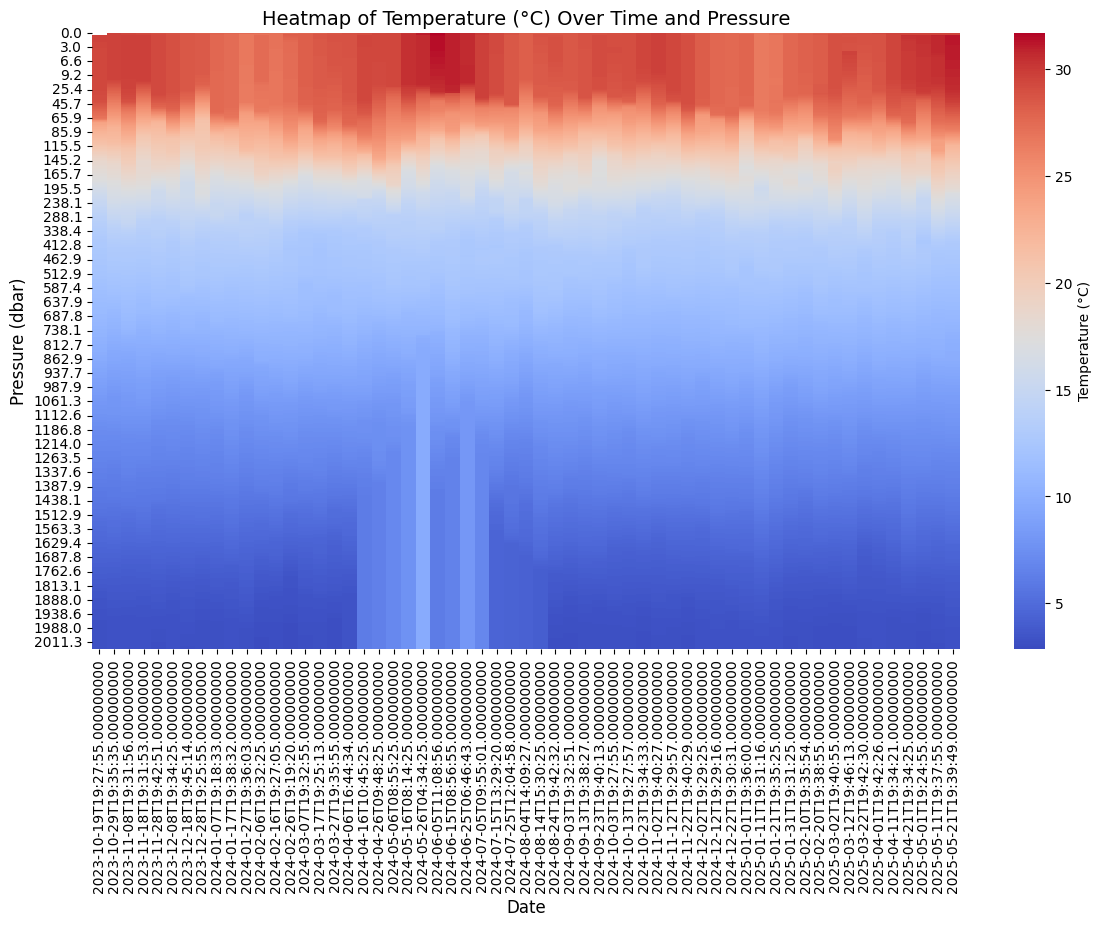

In [15]:
# Pivot and interpolate for smooth grid
piv = merged_df.pivot_table(index='pressure', columns='date', values='temperature')
piv_interp = piv.interpolate(method='linear', axis=0).interpolate(method='linear', axis=1)

fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(piv_interp, cmap='coolwarm', ax=ax, cbar_kws={'label': 'Temperature (°C)'})
ax.set_title('Heatmap of Temperature (°C) Over Time and Pressure', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Pressure (dbar)', fontsize=12)
plt.show()

## 3D Interactive Scatter Plot
This interactive 3D scatter plot, created with Plotly, displays temperature (x-axis), salinity (y-axis), and pressure (z-axis), colored by date. Researchers can rotate and zoom to explore the data's multi-dimensional structure. The reversed z-axis ensures depth increases downward, mimicking oceanographic conventions. The plot highlights temporal changes in water column properties.

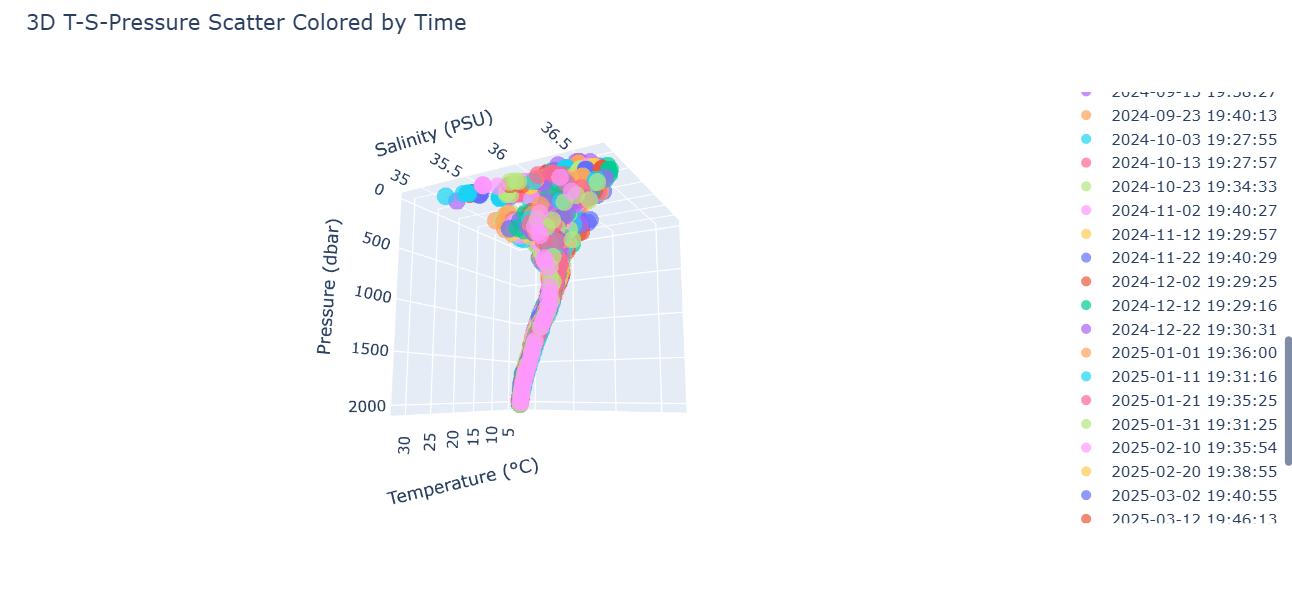

In [ ]:
fig = px.scatter_3d(
    merged_df,
    x='temperature',
    y='salinity',
    z='pressure',
    color='date',
    opacity=0.7,
    title='3D T-S-Pressure Scatter Colored by Time',
    labels={'temperature': 'Temperature (°C)', 'salinity': 'Salinity (PSU)', 'pressure': 'Pressure (dbar)'}
)
fig.update_layout(scene=dict(zaxis_autorange='reversed'))
fig.show()

## 3D Surface Plot of Temperature
This 3D surface plot visualizes interpolated temperature over time (days since start) and pressure. The cubic interpolation creates a smooth surface, and the Viridis colormap enhances visual appeal. This plot provides a stunning view of the thermocline's evolution, helping researchers identify trends in ocean temperature structure over depth and time.

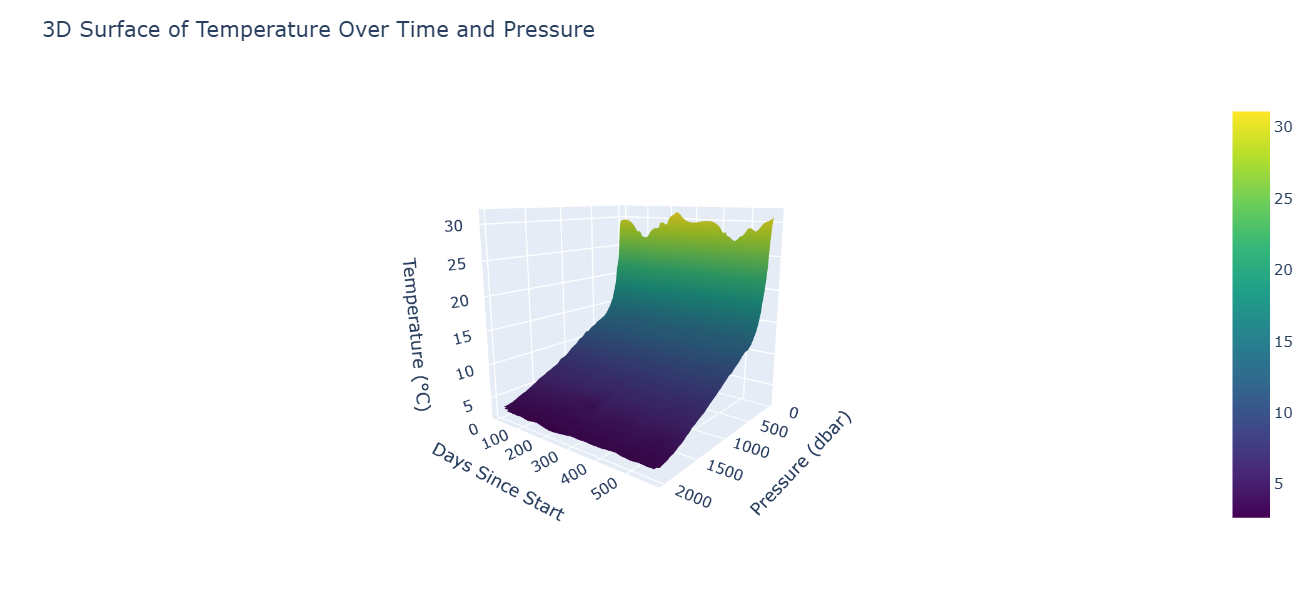

In [ ]:
# Prepare grid for surface
dates_num = (merged_df['date'] - merged_df['date'].min()).dt.days
pressures = np.linspace(merged_df['pressure'].min(), merged_df['pressure'].max(), 100)
dates_grid = np.linspace(dates_num.min(), dates_num.max(), 100)
X, Y = np.meshgrid(dates_grid, pressures)
Z = griddata((dates_num, merged_df['pressure']), merged_df['temperature'], (X, Y), method='cubic')

fig = go.Figure(data=[
    go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')
])
fig.update_layout(
    title='3D Surface of Temperature Over Time and Pressure',
    scene=dict(
        xaxis_title='Days Since Start',
        yaxis_title='Pressure (dbar)',
        zaxis_title='Temperature (°C)',
        yaxis=dict(autorange='reversed')
    )
)
fig.show()

## Animated Contour Plot of Salinity
This animated contour plot shows salinity contours as a function of temperature (x-axis) and pressure (y-axis), with each frame representing a cycle. The animation, created with Plotly, allows researchers to observe how salinity distributions evolve over time. The reversed y-axis ensures depth increases downward, and the colorbar indicates salinity values.

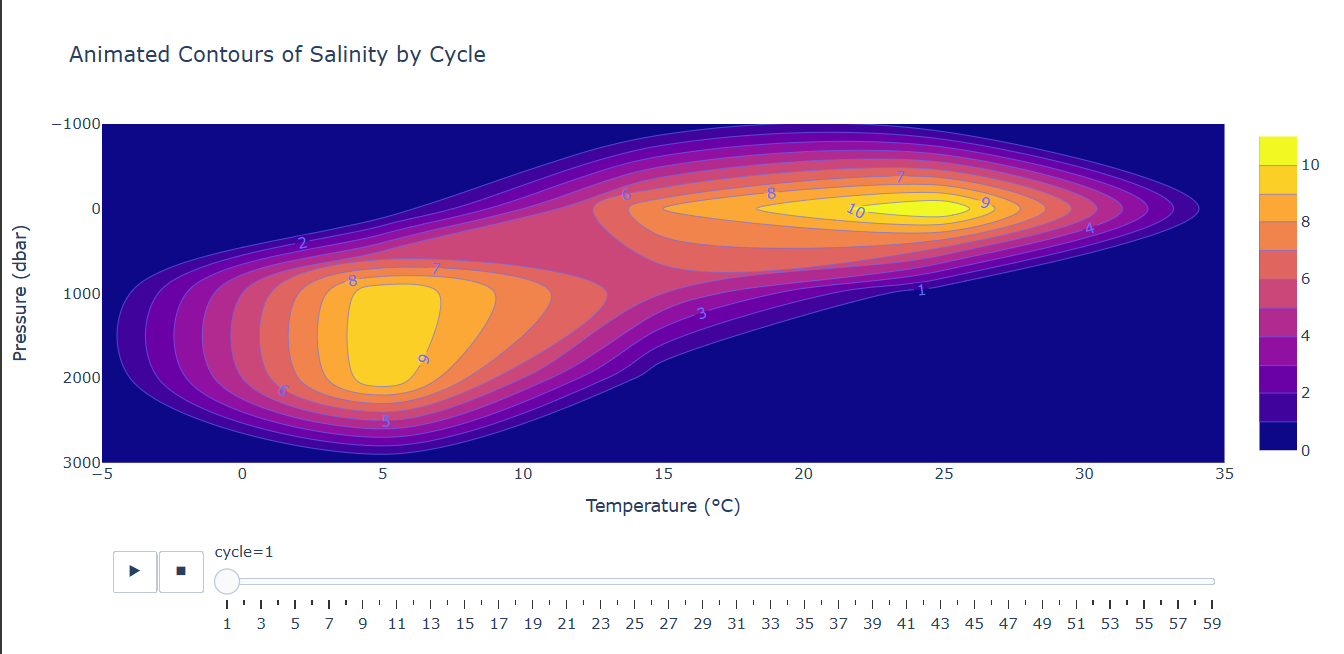

In [ ]:
fig = px.density_contour(
    merged_df,
    x='temperature',
    y='pressure',
    z='salinity',
    animation_frame='cycle',
    title='Animated Contours of Salinity by Cycle',
    labels={'temperature': 'Temperature (°C)', 'pressure': 'Pressure (dbar)', 'salinity': 'Salinity (PSU)'}
)
fig.update_yaxes(autorange='reversed')
fig.update_traces(contours_coloring='fill', contours_showlabels=True)
fig.show()

## Conclusion and Insights
The visualizations provide a comprehensive analysis of the Argo float 1902671 data:
- **Waterfall Plot**: Highlights the vertical temperature structure and its changes over cycles, useful for studying thermocline dynamics.
- **T-S Diagram**: Reveals water mass characteristics through temperature-salinity relationships, with pressure coloring indicating depth-dependent properties.
- **Heatmap**: Shows temporal and depth-related temperature trends, useful for identifying seasonal or long-term changes.
- **3D Scatter**: Offers an interactive view of temperature, salinity, and pressure relationships over time.
- **3D Surface**: Visualizes the continuous evolution of temperature across depth and time.
- **Animated Contours**: Tracks salinity changes across cycles, highlighting dynamic ocean processes.

**Scientific Insights**:
- The data shows a clear thermocline (rapid temperature decrease with depth) around 100–300 dbar, typical of tropical oceans near the deployment location (17.44°N, 69.31°E).
- Salinity variations suggest mixing of water masses, possibly influenced by regional currents or seasonal effects.
- The lack of position data limits trajectory analysis. To include float movement, integrate latitude/longitude from Argo databases (e.g., Argovis or Euro-Argo).

**Future Work**:
- Add trajectory data to map the float’s path.
- Perform statistical analysis (e.g., anomaly detection, clustering) to identify water masses or unusual events.
- Compare with other Argo floats in the region for broader oceanographic context.

This notebook provides a visually stunning and scientifically robust framework for analyzing Argo float data, aiding researchers in understanding ocean dynamics in the Indian Ocean.